# Comparison of RandomForest with SMOTE vs Augmented Data

In this blog I'd like to show the difference deep tabular augmentation can have when training a Random Forest on a highly biased data base. In this case, we have a look at credit card fraud, where fraud itself is is way less represented than non-fraud. I want to compare the popular SMOTE technique with the Deep Learning Augmentation.

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
import mlprepare as mlp
import deep_tabular_augmentation as dta
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_PATH = 'data/creditcard.csv'

df = pd.read_csv(DATA_PATH)

Let's have a short look at the data:

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Also, let's have a look of how many more non-fraud cases we have compared to fraud cases:

In [4]:
difference_in_class_occurences = df['Class'].value_counts()[0]-df['Class'].value_counts()[1]
difference_in_class_occurences

283823

In order to make use of the deep tabular augmentation we need to scale the data and then use only those cases, in which class we are interested in, in this case "Class" is equal to 1.

In [5]:
X_train, X_test, y_train, y_test = mlp.split_df(df, dep_var='Class', test_size=0.3, split_mode='random')

x_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)

X_test_scaled = x_scaler.transform(X_test)

X_train_fraud = X_train_scaled[np.where(y_train==1)[0]]
X_test_fraud = X_test_scaled[np.where(y_test==1)[0]]

For our model to work we need to put our data in a DataLoader (here I use the DataBunch Class from deep data augmentation).

In [6]:
datasets = dta.create_datasets(X_train_fraud, y_train.values[np.where(y_train==1)], X_test_fraud, y_test.values[np.where(y_test==1)])
data = dta.DataBunch(*dta.create_loaders(datasets, bs=1024))

Now we're already good to go. We can define our Variational Encoder Architecture (here: 50->12->12->5->12->12->50) and then use the LearningRate Finder to tell us the best Learning rate:

In [7]:
D_in = X_train_fraud.shape[1]
VAE_arch = [50, 12, 12]
target_name = 'Class'
target_class = 1
df_cols = list(df.columns)

model = dta.Autoencoder(D_in, VAE_arch, latent_dim=5).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = dta.customLoss()

In [8]:
learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)

run = dta.Runner(cb_funcs=[dta.LR_Find, dta.Recorder])

run.fit(100, learn)

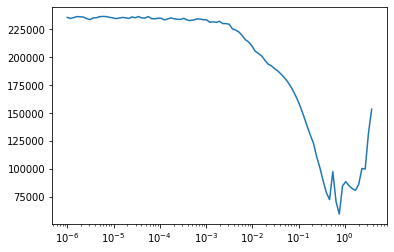

In [9]:
run.recorder.plot(skip_last=5)

We set up a desirable learning rate and scheduler for our learning rate:

In [10]:
sched = dta.combine_scheds([0.3, 0.7], [dta.sched_cos(0.01, 0.1), dta.sched_cos(0.1, 0.01)])

Now, let's train the model:

In [11]:
cbfs = [partial(dta.LossTracker, show_every=50), dta.Recorder, partial(dta.ParamScheduler, 'lr', sched)]
model = dta.Autoencoder(D_in, VAE_arch, latent_dim=20).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)
run = dta.Runner(cb_funcs=cbfs)
run.fit(400, learn)

epoch: 50
train loss is: 235061.25
validation loss is: 106866.8203125
epoch: 100
train loss is: 170239.125
validation loss is: 75203.1640625
epoch: 150
train loss is: 120978.515625
validation loss is: 149698.640625
epoch: 200
train loss is: 87892.9296875
validation loss is: 129409.578125
epoch: 250
train loss is: 69032.921875
validation loss is: 100179.2109375
epoch: 300
train loss is: 57270.7421875
validation loss is: 81863.3671875
epoch: 350
train loss is: 49296.77734375
validation loss is: 69471.0546875
epoch: 400
train loss is: 43532.91015625
validation loss is: 60559.10546875


Let's see how the created data looks like:

In [15]:
# take 25% of real standard deviation
sigma = list(df[df['Class']==1][df_cols].std()*0.25)
df_fake_with_noise = run.predict_with_noise_df(learn, no_samples=1000, mu=0, sigma=sigma, scaler=x_scaler)

In [16]:
df_fake_with_noise.describe().loc[['mean']]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
mean,92906.046144,-2.386666,1.423976,-4.081175,2.416863,-1.921564,-1.03062,-3.456801,1.271546,-1.98204,...,1.012225,0.446317,0.208623,-0.239074,-0.014651,0.049692,0.773771,-0.056647,131.269742,1.0


Now we use SMOTE for creating data

In [18]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [26]:
y_train.value_counts()

0    199032
1       332
Name: Class, dtype: int64

In [25]:
y_res.value_counts()

0    199032
1    199032
Name: Class, dtype: int64

So basically SMOTE creates as many entries of the minority class until we have the same amount of cases in both classes. We can do this with the DeepLearning Augmenter as well:

In [28]:
difference_in_trainset = y_train.value_counts()[0]-y_train.value_counts()[1]
df_fake_with_noise = run.predict_with_noise_df(learn, no_samples=difference_in_trainset, mu=0, sigma=sigma, scaler=x_scaler)
df_fake_with_noise.shape

(198700, 31)

While SMOTE creates these synthetic data in almost no-time, the DeepLearning Augmentation takes about a minute.

## Train Random Forest

We want to compare how the built-in class_weight functionality performs vs the new approach vs SMOTE. So we will build three trainsets: the original one, the one with additional data from SMOTE, and the one with additional data from DeepLearning Augmentation.

In [29]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
train_df_fake_with_noise = pd.concat([train_df, df_fake_with_noise])

To make things easier to understand, let's define the datasets on which to train and on which to assess the results:

In [30]:
X_train, X_test, X_train_aug = train_df.iloc[:,:30].values, test_df.iloc[:,:30].values, train_df_fake_with_noise.iloc[:,:30].values
y_train, y_test, y_train_aug = train_df.iloc[:,30].values, test_df.iloc[:,30].values, train_df_fake_with_noise.iloc[:,30].values

In [45]:
X_train.shape, X_train_aug.shape, X_res.shape

((199364, 30), (398064, 30), (398064, 30))

In [46]:
y_train.shape, y_train_aug.shape, y_res.shape

((199364,), (398064,), (398064,))

First, let's train model on the original data while using the differences in class occurences as weights.

In [31]:
def rf(xs, y, n_estimators=40, max_samples=500,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True, class_weight={0:1,1:difference_in_class_occurences}).fit(xs, y)

In [32]:
m = rf(X_train, y_train)
confusion_matrix(y_test, np.round(m.predict(X_test)))

array([[85304,     3],
       [  132,     4]])

Then we use the SMOTE data:

In [33]:
def rf_aug(xs, y, n_estimators=40, max_samples=500,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [42]:
m_smote = rf_aug(X_res.values, y_res)
confusion_matrix(y_test, np.round(m_smote.predict(X_test)))

array([[84024,  1283],
       [   11,   125]])

Finally, we use the augmented dataframe:

In [41]:
m_aug = rf_aug(X_train_aug, y_train_aug)
confusion_matrix(y_test, np.round(m_aug.predict(X_test)))

array([[85249,    58],
       [   29,   107]])

Let's have a look at the Classification Reports:

In [38]:
from sklearn.metrics import classification_report
target_names = ['no-fraud', 'fraud']
print(classification_report(y_test, np.round(m.predict(X_test)), target_names=target_names))

              precision    recall  f1-score   support

    no-fraud       1.00      1.00      1.00     85307
       fraud       0.57      0.03      0.06       136

    accuracy                           1.00     85443
   macro avg       0.78      0.51      0.53     85443
weighted avg       1.00      1.00      1.00     85443



In [43]:
print(classification_report(y_test, np.round(m_smote.predict(X_test)), target_names=target_names))

              precision    recall  f1-score   support

    no-fraud       1.00      0.98      0.99     85307
       fraud       0.09      0.92      0.16       136

    accuracy                           0.98     85443
   macro avg       0.54      0.95      0.58     85443
weighted avg       1.00      0.98      0.99     85443



In [44]:
print(classification_report(y_test, np.round(m_aug.predict(X_test)), target_names=target_names))

              precision    recall  f1-score   support

    no-fraud       1.00      1.00      1.00     85307
       fraud       0.65      0.79      0.71       136

    accuracy                           1.00     85443
   macro avg       0.82      0.89      0.86     85443
weighted avg       1.00      1.00      1.00     85443



We see quite huge differences between the three approaches. Simply attaching a higher weight to the fraud-class didn't help at all, we were only able to identify 4 fraud cases correctly. The SMOTE approach lead to way more identified fraud cases, it found 125 cases out of 136. This leads to an recall of 0.92. However, this comes at a cost: we have astonishing 1283 missclassified fraud cases, leading to a precision in the fraud case of 0.09. The Deep Learning Augmentation correctly predicted 107 out of the 136 cases while only misclassifying 58 cases - this leads to a precision of 0.65 in the fraud case. 

To conclude, I think this blog was able to show the merits of Deep Learning Augmentation. While increasing the correctly identified fraud cases we were also able to keep a high precision in this case, meaning we only have a few misclassified cases. While SMOTE was able to correctly identify a few more fraud cases it did also create a huge amount of misclassified fraud cases which might be costly when it comes to resource allocation.

Lasse